In [1]:
# If no torchvision locally, uncomment the next line and run it once:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

import os, random, math, time 
from pathlib import Path 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 

import torchvision 
from torchvision import datasets, transforms 

import numpy as np 
import matplotlib.pyplot as plt 

SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)
DEVICE

device(type='cpu')

## 1. Data: download transform and inspect
We download MNIST (70k images of handwritten digits, 28*28 grayscale) using `torchvision.datasets.MNIST`

**Transforms used** :
* `ToTensor()` : converts PIL images to PyTorch tensors in [0,1]
* `Normalize((0.1307,), (0.3081,))` standardizes pixel values using the dataset's mean and std for faster, stabler training

In [2]:
DATA_DIR = Path("./data")

transform = transforms.Compose([
    transforms.ToTensor(),                    # [H,W] -> [1,H,W], values in [0,1]
    transforms.Normalize((0.1307,), (0.3081,))# standardize using MNIST stats
])

train_ds = torchvision.datasets.MNIST(
    root=DATA_DIR,
    train=True, 
    download=True,
    transform=transform
)

test_ds = torchvision.datasets.MNIST(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform
)

print(train_ds)
print(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## 2. Peek at a sample and its statistics 
Let's pull a single (image, label) pair and check:

* the label (integer 0–9),
* the tensor shape (should be [1, 28, 28]),
* the value range, mean, and std after normalization,
* a visualization of the image.

Label: 4
Tensor shape: torch.Size([1, 28, 28])
Min / Max: -0.4242129623889923 2.821486711502075
Mean / Std: -0.10855599492788315 0.835247278213501


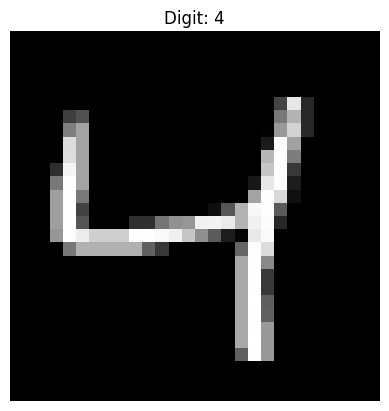

In [3]:
x, y = train_ds[2]
print("Label:", y)
print("Tensor shape:", x.shape) 

print("Min / Max:", float(x.min()), float(x.max()))
print("Mean / Std:", float(x.mean()), float(x.std()))

plt.figure() 
plt.title(f"Digit: {y}")
# Undo normalization for display: x*std + mean
x_vis = x * 0.3081 + 0.1307
plt.imshow(x_vis[0].numpy(), cmap="gray")
plt.axis("off")
plt.show()

## 3. Create DataLoaders
We wrap the datasets in `DataLoader`s to handle batching and (optionally) shuffling.
* **Batch size** : 64 is a common default for MNIST
* **Shuffle** : `True` for training; `False` for test 

In [4]:
BATCH_SIZE = 64

train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True if DEVICE.type=="cuda" else False
)

test_dl = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True if DEVICE.type=="cuda" else False
)

len(train_dl), len(test_dl)

(938, 157)